This project combining Segmentation, Image Editing and Generation by using Segment Anything from Meta AI for Segmentation(Apache Licence 2.0) and Stable Diffusion

# Installing Libraries

In [ ]:
!pip install -q regex tqdm
!pip install -q diffusers transformers accelerate scipy
!pip install -q -U xformers
!pip install -q opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 62.0 MB/s eta 0:00:00


In [ ]:
!pip install -q git+https://github.com/facebookresearch/segment-anything.git
!pip install -q pycocotools matplotlib onnxruntime onnx

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 91.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.3 MB/s eta 0:00:00


# Importing Libraries

In [ ]:
import torch
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image, to_tensor

import PIL, cv2
from PIL import Image

from io import BytesIO
from IPython.display import display
import base64, json, requests
from matplotlib import pyplot as plt

import numpy as np
import copy

from numpy import asarray

import sys

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

## Download Segment Anything Checkpoint

Download the checkpoint file called sam_vit_h_4b8939.pth and put it on the same folder

In [ ]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2024-10-14 17:24:12--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.124, 108.157.254.15, 108.157.254.102, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   257MB/s    in 13s     

2024-10-14 17:24:25 (184 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



# Importing Stable Diffusion Model

In [ ]:
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler, StableDiffusionInpaintPipeline
"""
first one allow inpaint pipeline. Inpainting process of replacing, editing in part of image
new generation. Second one scheduler when we are running a diffusion generative model in inference
Start from noise or image with noise gradually new picture. That gradual porcess of going from the
noise to new generation can be done many different ways with algorithms. In here we are asking the diffusers
library to give us a method for one specific algorithm. We're asking for the one that called eular.
"""

model_dir="stabilityai/stable-diffusion-2-inpainting"

"""
We have to setup inpainting architecture but we have to tell diffusers, hugging face which
of them. Because hugging face has like hundreds of models and architectures and not one stable
diffusion. We say take the model in stabilityai folder and model.
"""

#Schedular determine the algorithm used to produce new samples during denoising process
scheduler = EulerDiscreteScheduler.from_pretrained(model_dir, subfolder = "scheduler")
# from_pretrained means in relation to an architecture that has already be trained

pipe = StableDiffusionInpaintPipeline.from_pretrained(model_dir,
                                                      scheduler = scheduler,
                                                      revision = "fp16",
                                                      torch_dtype = torch.float16)
"""
pipe is a pipeline. In order to run a stable diffusion, we need to do a lot of different
steps. A pipeline with many different steps. Hugging face diffusion models give you all of the
pipelines all together in one place. We can run model with different bits. In this case we are running model with
floating point 16 bits. We have the pipeline now for running the model in inference mode.

"""
pipe = pipe.to("cuda") #move it to gpu
pipe.enable_xformers_memory_efficient_attention()
# Internally stable diffusion is using transformers. Xformers makes the architecture more efficient.


model_index.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_loading_utils.py:219: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2-inpainting via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
vae/diffusion_pytorch_model.safetensors not found


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/635 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/681M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `

# Image

Source Image Size: 3157 x 4736
Resized Image Size: (512, 512)


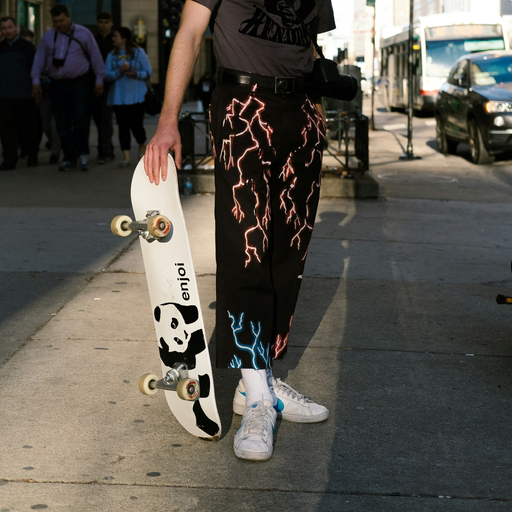

In [ ]:
# we have to save it in the same folder with notebook and PTH file with weights of segmentation arch

# we need to resize our image because it is very big originally
target_width, target_height = 512, 512
# ıf we have memory issues we can reduce it more

source_image = Image.open('diffusion-example-skateboard.jpg')
# to load and open image. Pillow lib

width, height = source_image.size
print(f"Source Image Size: {width} x {height}")

# we make the image square
source_image = source_image.crop((0, height-width, width, height))
# box=(left, upper, right, lower)
# Crop method inside pillow lib. We want a square so we need to minimize it.

# We resize the image
source_image = source_image.resize((target_width, target_height), Image.LANCZOS)
print(f"Resized Image Size: {source_image.size}")
# result will be pillow format

# we convert the image into a an array in order to use it later with the segmentation model
segmentation_image = asarray(source_image)
display(source_image)

# Initializing Segment Anything Model(SAM)

In [ ]:
sam_checkpoint = "sam_vit_h_4b8939.pth" # file we downloaded before
# checkpoint is the file that contains the pre-trained weights of the network
model_type = "vit_h"
# meta tells us these

device = "cuda"

sam = sam_model_registry[model_type](checkpoint = sam_checkpoint)
# this is gonna initialize the segmentation architecture
sam.to(device = device)

# pay attention to the pred_iou_thresh, the lower the more masks it will generate. Make it higher
# to generate masks only of good quality and less number of them

"""
    a filtering threshold in [0,1], using the models predicted mask quality. IOU means intersection
    over union used very often to evalueate the quality of a segmentation proces. If it is very low means
    very bad match. If it approaches one it will be good. If we use 0.2 it is gonna produce lots of mask
    because it gives us above threshold and a lot of them.
"""
mask_generator = SamAutomaticMaskGenerator(
    model = sam,
    points_per_side = 32,
    pred_iou_thresh = 0.99,
    stability_score_thresh = 0.92,
    crop_n_layers = 1,
    crop_n_points_downscale_factor = 2,
    min_mask_region_area = 100 # requires open-cv to run post-processing

)

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


# Run Segmentation Model

In [ ]:
masks = mask_generator.generate(segmentation_image)
# run it with generate applying to segmentation_image. Masks store it

# Print number of masks generated and the keys attached to each of them
print(f"Number of masks generated: {len(masks)}")
print(masks[0].keys())

"""
each of the masks are dictionary that have the key
Segmentation key contains the actual black and white image that is the mask itself.
and different keys different values that give us an idea of what is the size of the mask,
quality ıf the mask etc. We only care about first one and IOU as well.


Intersection Over Union (IoU) tell us the degree of overlap between two boxes.
In the case of object detection and segmentation, it refers to the overlap of
the Ground Truth and Prediction region

"""

Number of masks generated: 20
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


'\neach of the masks are dictionary that have the key \nSegmentation key contains the actual black and white image that is the mask itself.\nand different keys different values that give us an idea of what is the size of the mask,\nquality ıf the mask etc. We only care about first one and IOU as well.\n\n\nIntersection Over Union (IoU) tell us the degree of overlap between two boxes.\nIn the case of object detection and segmentation, it refers to the overlap of \nthe Ground Truth and Prediction region\n\n'

# Declare function to visualize the masks generated together with a number that identifies each of them

In [ ]:
# We want to see the mask and pick one of them
def show_anns(anns):
  if len(anns) == 0:
    return

  # Sorting masks by area in descending order
  sorted_anns = sorted(enumerate(anns), key = (lambda x: x[1]['area']), reverse = True)
  ax = plt.gca()

  # Disable autoscale to keep the image size consistent
  ax.set_autoscale_on(False)

  # Iterate through each mask and display it on top of the original image
  for original_idx, ann in sorted_anns:
    m = ann['segmentation']
    img = np.ones((m.shape[0], m.shape[1], 3))

    # Generate a random color for the mask
    color_mask = np.random.random((1, 3)).tolist()[0]
    for i in range(3):
      img[:,:,i] = color_mask[i]

    # Blend the mask with the image, using 0.35 as the alpha value for transparency
    ax.imshow(np.dstack((img, m*0.35)))

    # Find contours of the mask to compute the centroid
    contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
      cnt = contours[0]
      M = cv2.moments(cnt)

      # Compute the centroid of the mask if the moment is non-zero
      if M['m00'] !=0:
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])

        # Display the original index number (1-based) at the centroid of the mask
        # The text is white, bold, and has a font size of 16
        ax.text(cx, cy, str(original_idx + 1), color = 'white', fontsize = 16, ha = 'center', va = 'center', fontweight = 'bold')


# Displaying masks

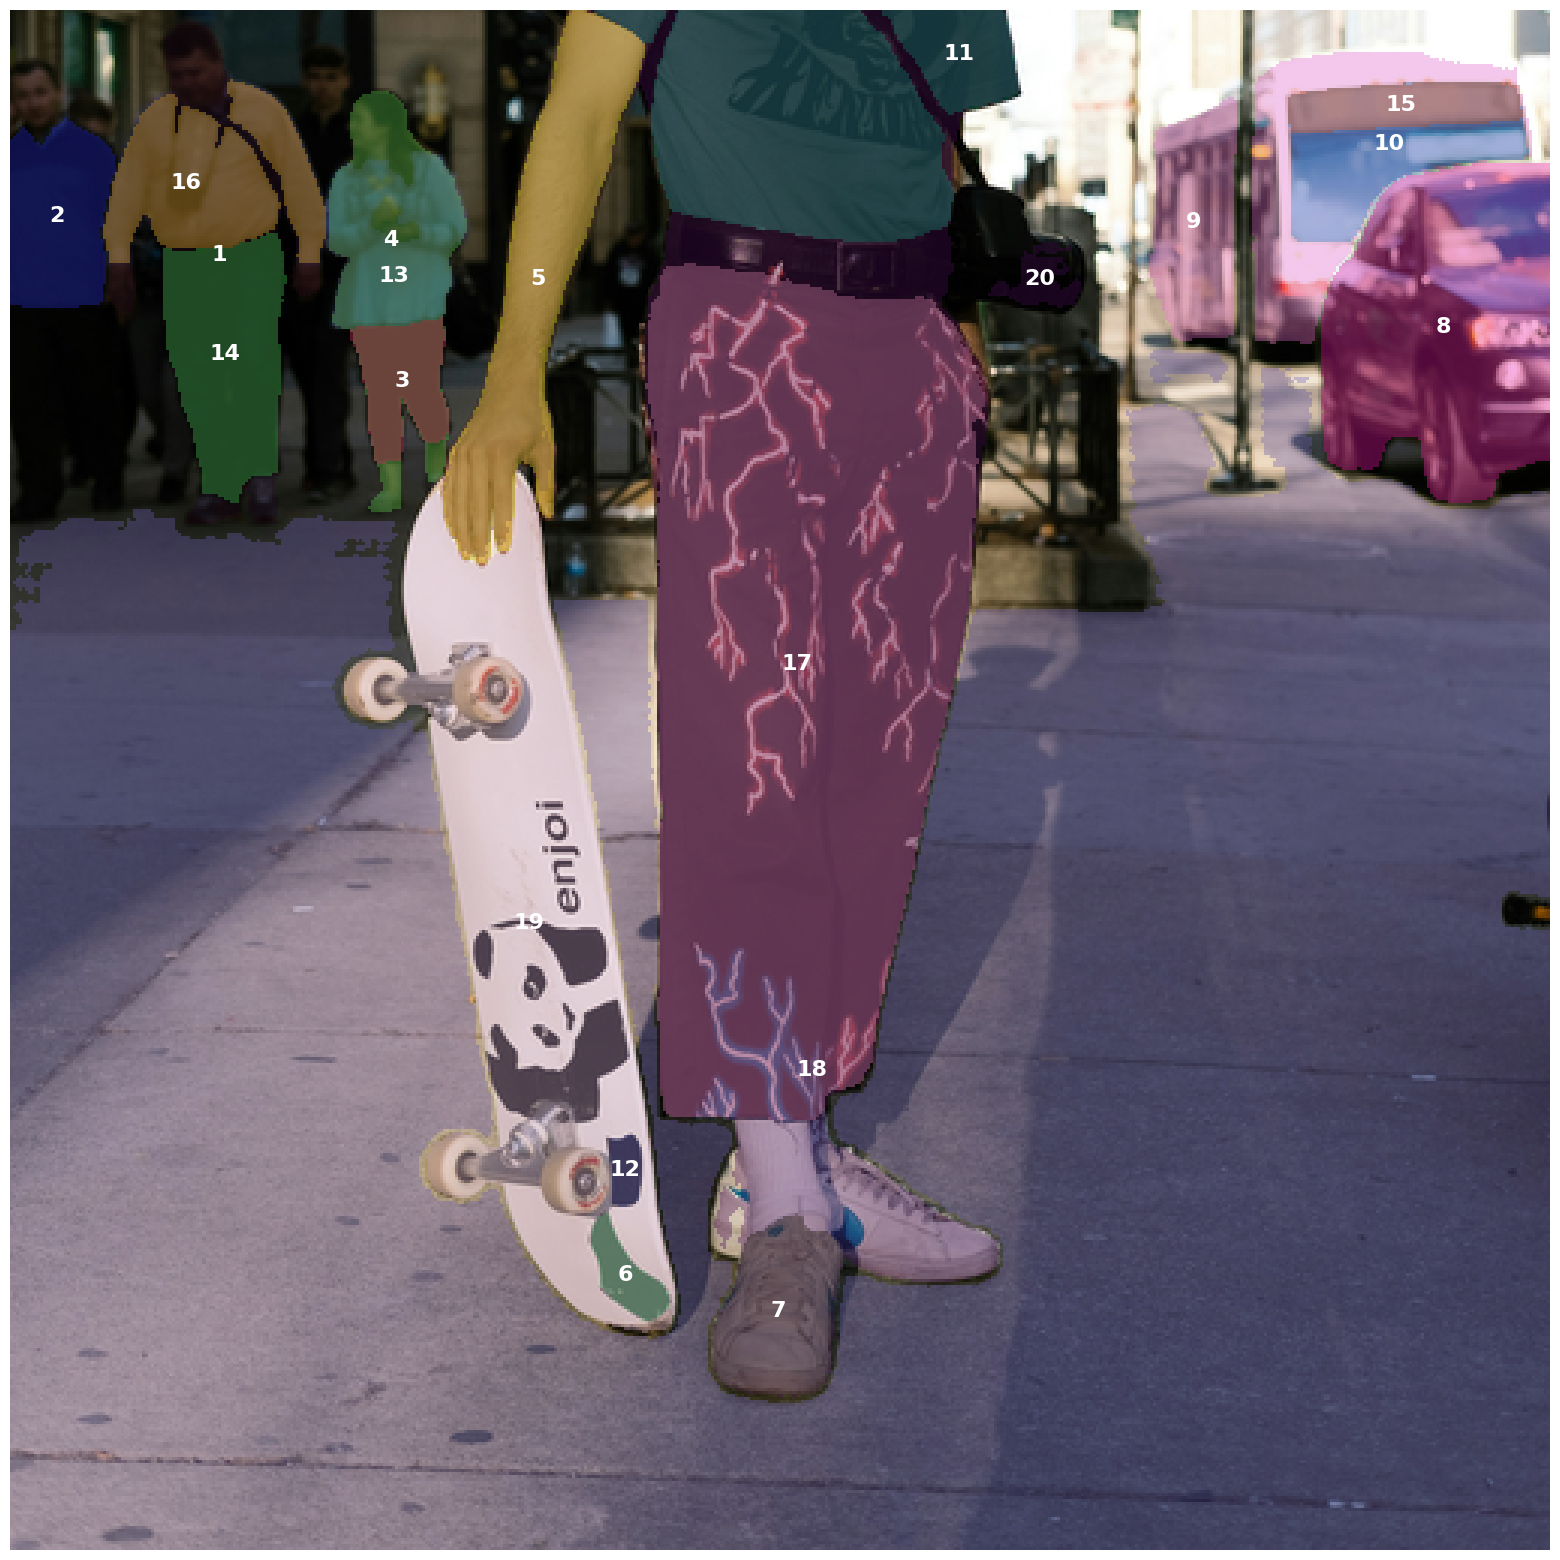

In [ ]:
# matplotlib we show original source image and execute the functions which is putting all the
# masks on top of it
plt.figure(figsize = (20,20))
plt.imshow(source_image)
show_anns(masks) # use masks[:-x] to only display the first masks of the list
plt.axis('off')
plt.show()

## Explore one of the keys of the mask

In [ ]:
# Take a look at those values that the segmentation model has produced in the
# dictionaries of the mask.
#Lets look at the area and the IoU

for i, values in enumerate(masks):
  print(f"{i}: Area: {values['area']} | IOU: {values['predicted_iou']}")

  # If IoU's are close to 1 means very precise
  # IoU: 0 means no overlap and 1 means perfect overlap

0: Area: 6762 | IOU: 1.0026130676269531
1: Area: 1867 | IOU: 0.9927949905395508
2: Area: 1087 | IOU: 0.9923704266548157
3: Area: 2001 | IOU: 0.9913965463638306
4: Area: 4444 | IOU: 0.9910814762115479
5: Area: 443 | IOU: 1.002402424812317
6: Area: 1954 | IOU: 0.9976187944412231
7: Area: 7085 | IOU: 1.0184005498886108
8: Area: 6980 | IOU: 0.9992183446884155
9: Area: 2760 | IOU: 0.9962372779846191
10: Area: 7650 | IOU: 0.9926134943962097
11: Area: 224 | IOU: 0.9921911358833313
12: Area: 3907 | IOU: 1.0389033555984497
13: Area: 2759 | IOU: 0.9995391368865967
14: Area: 1071 | IOU: 0.997935950756073
15: Area: 2855 | IOU: 0.990688681602478
16: Area: 25560 | IOU: 1.0363068580627441
17: Area: 136220 | IOU: 1.0256636142730713
18: Area: 13449 | IOU: 1.0015984773635864
19: Area: 44614 | IOU: 1.0015650987625122


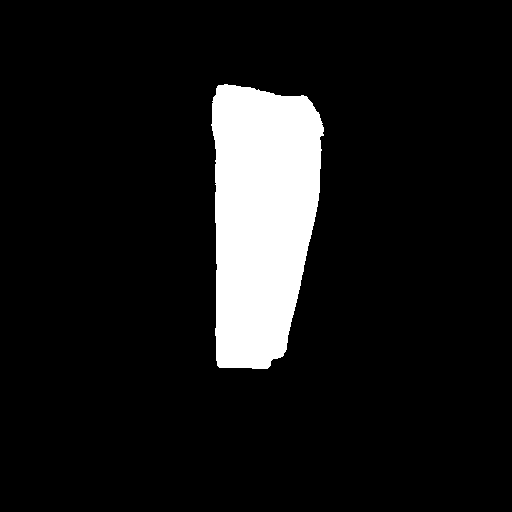

In [ ]:
# Decide which mask you want to do inpainting with. In this case we pick the skirt which is mask number 4
mask_index = 16

#segmentation mask is the mask number 4, and we access the segmentation key.
#In order to give it to the stable diffusion generative model, it has to be in the PIL format.
segmentation_mask=masks[mask_index]['segmentation']
stable_diffusion_mask=PIL.Image.fromarray(segmentation_mask)
display(stable_diffusion_mask)

# Setting up transformation prompts



In [ ]:
# We are gonna produce 4 results and 4 different prompts
num_images_per_prompt = 4
inpainting_prompts = ["a trouser full of skull", "clouds", "cyberpunk", "a trouser full of pandas"]

generator = torch.Generator(device = "cuda").manual_seed(10)


# Running Stable Difussion pipeline in inpainting mode

"""
we instantiate a list and we iterate through the four prompts and we call the pipeline of the
diffusers library of hugging face
"""

encoded_images = []
for i in range(num_images_per_prompt):
  image = pipe(prompt = inpainting_prompts[i],
               guidance_scale = 7.7,
               num_inference_steps = 65,
               generator = generator,
               image = source_image,
               mask_image = stable_diffusion_mask).images[0]
  encoded_images.append(image)

"""
guidance scale(1-12) how closely result is gonna match our prompt. If we pick less than 7 it
starts to be more creative, starts deviate more from our prompt. num_inference_steps is step
increase it may be more accurate but more slower and maybe not even more good
"""

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

'\nguidance scale(1-12) how closely result is gonna match our prompt. If we pick less than 7 it \nstarts to be more creative, starts deviate more from our prompt. num_inference_steps is step\nincrease it may be more accurate but more slower and maybe not even more good\n'

# Showing generation

In [ ]:
def create_image_grid(original_image, images, names, rows, columns):
    names = copy.copy(names)
    # Create a copy of the names list to avoid modifying the external variable
    images = copy.copy(images)
    # Create a copy of the images list to avoid modifying the external variable

    # Check if images is a tensor
    if torch.is_tensor(images):
        # Check if the number of tensor images and names is equal
        assert images.size(0) == len(names), "Number of images and names should be equal"

        # Check if there are enough images for the specified grid size
        assert images.size(0) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"

        # Convert tensor images to PIL images and apply sigmoid normalization
        images = [to_pil_image(torch.sigmoid(img)) for img in images]
    else:
        # Check if the number of PIL images and names is equal
        assert len(images) == len(names), "Number of images and names should be equal"

    # Check if there are enough images for the specified grid size
    assert len(images) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"

    # Add the original image to the beginning of the images list
    images.insert(0, original_image)

    # Add an empty name for the original image to the beginning of the names list
    names.insert(0, '')

    # Create a figure with specified rows and columns
    fig, axes = plt.subplots(rows, columns, figsize=(15, 15))

    # Iterate through the images and names
    for idx, (img, name) in enumerate(zip(images, names)):
        # Calculate the row and column index for the current image
        row, col = divmod(idx, columns)

        # Add the image to the grid
        axes[row, col].imshow(img, cmap='gray' if idx > 0 and torch.is_tensor(images) else None)

        # Set the title (name) for the subplot
        axes[row, col].set_title(name)

        # Turn off axes for the subplot
        axes[row, col].axis('off')

    # Iterate through unused grid cells
    for idx in range(len(images), rows * columns):
        # Calculate the row and column index for the current cell
        row, col = divmod(idx, columns)

        # Turn off axes for the unused grid cell
        axes[row, col].axis('off')

    # Adjust the subplot positions to eliminate overlaps
    plt.tight_layout()

    # Display the grid of images with their names
    plt.show()

"""
this function is gonna take the source image and a list of result images, and list of the prompts associated
with the results images, and number of rows and columns and it is gonna create a grid. And it is gonna put the original image,
and result images with prompts associated on top of them in this grid
"""

'\nthis function is gonna take the source image and a list of result images, and list of the prompts associated\nwith the results images, and number of rows and columns and it is gonna create a grid. And it is gonna put the original image,\nand result images with prompts associated on top of them in this grid\n'

In [ ]:
create_image_grid(source_image, encoded_images, inpainting_prompts, 2, 3)

Output hidden; open in https://colab.research.google.com to view.